# Análisis Exploratorio de los Microdatos del Censo 2017

Por [**Eduardo Graells-Garrido** (@carnby)](https://twitter.com/carnby), <egraells@udd.cl>

En este notebook muestro cómo cargar los primeros datos disponibles del Censo 2017 para generar mapas de coropletas. 

Particularmente haremos tres mapas:

  * ¿Cuál es la distribución de les inmigrantes en Santiago? 
  * ¿Cuál es la distribución de las personas mayores de 65 años en Santiago?
  * ¿Dónde viven más hombres o mujeres?

Los datos se han obtenido de las siguientes fuentes (y están incluidos en este repositorio):

  * [Microdatos del Censo 2017](http://www.censo2017.cl/microdatos/)
  * [Shapefile de Distritos Censales](https://github.com/justinelliotmeyers/official_chile_2017_census_boundary_shapefile)
  * [Shapefile de áreas urbanas del país](https://www.bcn.cl/siit/mapas_vectoriales/index_html)

Comencemos.

## Preámbulo

Aquí cargamos las bibliotecas que necesitamos utilizar y configuramos el sistema.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font='Linux Biolinum O', context='poster', palette='viridis')
%config InlineBackend.figure_format='retina'

In [2]:
pd.set_option('display.max_columns', None)

## Funciones Auxiliares

Éstos son los métodos que utilizaremos para generar los mapas.

Primero, utilizo una función que viene en la biblioteca [geopandas](http://geopandas.org/index.html), pero que debí modificar para incorporar una opción adicional de partición de datos. El código original está [aquí](https://github.com/geopandas/geopandas/blob/master/geopandas/plotting.py).

In [3]:
# from geopandas
def __pysal_choro(values, scheme, k=5):
    """
    Wrapper for choropleth schemes from PySAL for use with plot_dataframe
    Parameters
    ----------
    values
        Series to be plotted
    scheme : str
        One of pysal.esda.mapclassify classification schemes
        Options are 'Equal_interval', 'Quantiles', 'Fisher_Jenks'
    k : int
        number of classes (2 <= k <=9)
    Returns
    -------
    binning
        Binning objects that holds the Series with values replaced with
        class identifier and the bins.
    """
    try:
        from pysal.esda.mapclassify import (
            Quantiles, Equal_Interval, Fisher_Jenks, User_Defined)
        schemes = {}
        schemes['equal_interval'] = Equal_Interval
        schemes['quantiles'] = Quantiles
        schemes['fisher_jenks'] = Fisher_Jenks
        schemes['user_defined'] = User_Defined
        scheme = scheme.lower()
        if scheme not in schemes:
            raise ValueError("Invalid scheme. Scheme must be in the"
                             " set: %r" % schemes.keys())
        binning = schemes[scheme](values, k)
        return binning
    except ImportError:
        raise ImportError("PySAL is required to use the 'scheme' keyword")


Aquí defino la función `choropleth` que toma los datos y genera los mapas. Está un poco fea porque es una función de uso interno, que espero algún día retocar lo suficiente como para convertir en una biblioteca que sirva a otres.

Por supuesto, esto incluye código de otras fuentes también. De la misma `geopandas` hasta un código auxiliar para la escala de colores que encontré aquí: [Fix your matplotlib colorbars!](http://joseph-long.com/writing/colorbars/).

In [4]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.patches import Polygon, Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

def feature_to_patch(s):
    s_arr = np.array(s.exterior.xy).T
    return Polygon(s_arr, closed=False)

def colorbar(ax, collection, orientation='vertical', percent=3, **cbar_kws):
    divider = make_axes_locatable(ax)
    position = 'right' if orientation == 'vertical' else 'bottom'
    label = cbar_kws.pop('label', None)
    cax = divider.append_axes(position, size="{}%".format(percent), pad=0.05)
    cbar = plt.colorbar(collection, cax=cax, orientation=orientation, **cbar_kws)
    cbar.set_label(label)
    return cbar

def choropleth(geodf, figsize=12, column=None, scheme='fisher_jenks', 
                   user_bins=None,
                   n_colors=5, palette='viridis', alpha=0.75, cbar_orientation='vertical',
                   img_interpolation='hanning', cbar_fig_position=None, cbar_label=None, z=None, cbar_kws=None):
        
    bounds = geodf.total_bounds
    aspect = (bounds[2] - bounds[0]) / (bounds[3] - bounds[1])
    fig = plt.figure(figsize=(figsize, figsize / aspect))

    ax = plt.gca()
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_aspect(1)
    
    plt.axis('off')
    
    cbar_kws = cbar_kws if cbar_kws else {}
    
    choro = []
    patch_values = []
        
    for idx, row in geodf.iterrows():
        feature = row.geometry
        value = row[column]

        if feature.geom_type == 'Polygon':
            choro.append(feature_to_patch(feature))
            patch_values.append(value)
        elif feature.geom_type == 'MultiPolygon':
            for subfeature in feature:
                choro.append(feature_to_patch(subfeature))
                patch_values.append(value)
        else:
            continue

    binning = __pysal_choro(geodf[column], scheme=scheme, k=n_colors if scheme != 'user_defined' else user_bins)
    if scheme != 'user_defined':
        bins = np.insert(binning.bins, 0, geodf[column].min())
    else:
        bins = binning.bins

    palette_values = sns.color_palette(palette, n_colors=n_colors)
    cmap, norm = from_levels_and_colors(bins, palette_values, extend='neither')
    cmap.set_over(palette_values[-1], alpha=alpha)

    collection = PatchCollection(choro, linewidth=1, edgecolor='white', alpha=alpha, cmap=cmap, norm=norm)    
    collection.set_array(np.array(patch_values))

    cbar_label = cbar_label if cbar_label is not None else column

    cbar_kws = dict(shrink=0.5, label=cbar_label, ticks=bins)
    colorbar(ax, collection, orientation=cbar_orientation, **cbar_kws)        
        
    ax.add_collection(collection)
    plt.tight_layout()


## Carga de Datos

Comencemos. Lo primero que hacemos es cargar los datos. Aquí hacemos una serie de operaciones de modo de quedarnos solamente con la región metropolitana.

Es posible que mi manera de limpiar los datos no sea la adecuada. En tal caso, por favor escríbeme un correo o abre un _issue_ en este repositorio.

In [5]:
census = (pd.read_csv('./input/Censo2017_ManzanaEntidad_CSV/Censo2017_Manzanas.csv', sep=';')
          .merge(pd.read_csv('./input/Censo2017_ManzanaEntidad_CSV/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Urbano.csv', sep=';'))
          .pipe(lambda x: x[x.REGION == 13])
          .drop('ZONA', axis=1)
          .drop_duplicates()
         )
census.head()

,REGION,PROVINCIA,COMUNA,DC,AREA,ZC_LOC,MZ_ENT,ID_ZONA_LOC,ID_MANZENT,PERSONAS,HOMBRES,MUJERES,EDAD_0A5,EDAD_6A14,EDAD_15A64,EDAD_65YMAS,INMIGRANTES,PUEBLO,VIV_PART,VIV_COL,MATACEP,MATREC,MATIRREC,VPOMP,TOTAL_VIV,P03A_1,P03A_2,P03A_3,P03A_4,P03A_5,P03A_6,P03B_1,P03B_2,P03B_3,P03B_4,P03B_5,P03B_6,P03B_7,P03C_1,P03C_2,P03C_3,P03C_4,P03C_5,P05_1,P05_2,P05_3,P05_4,NOM_URBANO,CAT
531736,13,131,13101,1,1,1,3,1279,13101011001003,421,196,225,24,18,299,80,63,28,249,1,181,0,0,189,250,159,29,0,0,0,0,32,136,15,0,0,0,0,186,0,0,0,0,188,0,0,0,SANTIAGO,1
531741,13,131,13101,1,1,1,4,1279,13101011001004,185,90,95,*,*,137,41,22,20,154,0,111,0,0,115,154,108,5,0,0,0,0,1,108,2,0,0,0,0,113,0,0,0,0,113,0,0,0,SANTIAGO,1
531746,13,131,13101,1,1,1,5,1279,13101011001005,776,390,386,30,27,636,83,132,54,515,2,416,1,0,422,517,385,35,0,0,1,0,60,333,25,1,0,0,0,419,1,0,0,0,422,0,0,0,SANTIAGO,1
531751,13,131,13101,1,1,1,6,1279,13101011001006,416,209,207,14,10,337,55,59,51,292,1,222,1,0,225,293,196,28,0,0,1,0,91,114,19,0,0,0,0,224,0,0,0,0,222,0,0,0,SANTIAGO,1
531756,13,131,13101,1,1,1,7,1279,13101011001007,376,211,165,*,*,315,40,55,28,279,2,187,1,0,195,281,140,49,1,0,1,0,27,135,28,0,0,0,0,191,0,0,0,0,195,0,0,0,SANTIAGO,1


Creamos una lista con las variables que nos interesan.

In [6]:
count_columns = ['HOMBRES', 'MUJERES','EDAD_0A5', 'EDAD_6A14', 'EDAD_15A64', 'EDAD_65YMAS', 'INMIGRANTES']

Si vemos el manual de uso de la base de datos, hay ocasiones en los que esas columnas no tienen valor. Con esto lo arreglamos, reemplazando el valor anónimo por un 0.

In [7]:
for col in count_columns:
    census[col] = census[col].replace('*', 0).astype(np.int)

In [8]:
census.sample(10)

,REGION,PROVINCIA,COMUNA,DC,AREA,ZC_LOC,MZ_ENT,ID_ZONA_LOC,ID_MANZENT,PERSONAS,HOMBRES,MUJERES,EDAD_0A5,EDAD_6A14,EDAD_15A64,EDAD_65YMAS,INMIGRANTES,PUEBLO,VIV_PART,VIV_COL,MATACEP,MATREC,MATIRREC,VPOMP,TOTAL_VIV,P03A_1,P03A_2,P03A_3,P03A_4,P03A_5,P03A_6,P03B_1,P03B_2,P03B_3,P03B_4,P03B_5,P03B_6,P03B_7,P03C_1,P03C_2,P03C_3,P03C_4,P03C_5,P05_1,P05_2,P05_3,P05_4,NOM_URBANO,CAT
786292,13,132,13201,6,1,7,23,14569,13201061007023,93,45,48,9,14,66,4,0,15,24,0,24,0,0,24,24,0,24,0,0,0,0,0,0,24,0,0,0,0,24,0,0,0,0,24,0,0,0,PUENTE ALTO,1
742642,13,131,13129,3,1,2,14,1728,13129031002014,69,37,32,5,9,40,15,10,7,18,0,18,0,0,18,18,0,18,0,0,0,0,0,0,18,0,0,0,0,18,0,0,0,0,18,0,0,0,SAN JOAQUÍN,1
613447,13,131,13117,2,1,5,6,16011,13117021005006,175,91,84,17,18,125,15,52,12,47,0,32,9,5,46,47,6,21,14,2,3,0,15,0,26,0,0,5,0,40,2,4,0,0,46,0,0,0,LO PRADO,1
567496,13,131,13109,6,1,1,7,13281,13109061001007,110,53,57,5,19,69,17,13,10,29,0,23,4,1,29,29,3,17,8,1,0,0,5,0,22,0,0,1,0,24,3,1,0,0,28,0,0,0,LA CISTERNA,1
840754,13,136,13603,1,1,1,62,11003,13603011001062,307,155,152,30,34,207,36,15,19,104,0,63,34,1,98,104,4,16,54,23,1,0,7,0,89,1,0,1,0,82,4,7,5,0,98,0,0,0,LA ISLITA,1
681282,13,131,13123,4,1,9,7,808,13123041009007,478,231,247,29,36,326,87,51,26,222,0,204,1,0,206,222,202,4,0,0,0,0,9,187,10,0,0,0,0,204,0,1,0,0,206,0,0,0,PROVIDENCIA,1
775643,13,132,13201,2,1,6,21,10309,13201021006021,43,23,20,6,8,29,0,0,*,17,0,14,0,0,14,17,11,2,1,0,0,0,13,1,0,0,0,0,0,14,0,0,0,0,14,0,0,0,PUENTE ALTO,1
734387,13,131,13127,6,1,5,15,10582,13127061005015,347,174,173,26,28,245,48,30,22,100,0,79,20,0,99,100,5,73,11,8,2,0,11,1,87,0,0,0,0,89,6,2,2,0,99,0,0,0,RECOLETA,1
797233,13,133,13301,1,1,9,14,7877,13301011009014,93,47,46,7,11,66,9,5,15,31,0,28,1,0,29,31,0,29,0,0,0,0,0,0,29,0,0,0,0,28,0,1,0,0,29,0,0,0,SANTA MARTA DE LIRAY,2
833102,13,135,13501,1,1,8,22,341,13501011008022,37,17,20,0,14,16,0,0,*,12,0,8,3,0,11,12,0,11,0,0,0,0,6,0,5,0,0,0,0,8,3,0,0,0,11,0,0,0,MELIPILLA,1


Ahora sumemos la población por cada variable, agrupando por distrito censal.

In [9]:
dc_values = census.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'DC'])[count_columns].sum().reset_index().rename(columns={'DC': 'COD_DISTRI'})

In [10]:
dc_values.sample(5)

,REGION,PROVINCIA,COMUNA,COD_DISTRI,HOMBRES,MUJERES,EDAD_0A5,EDAD_6A14,EDAD_15A64,EDAD_65YMAS,INMIGRANTES
215,13,131,13121,4,6696,7237,845,1280,9053,2423,387
273,13,131,13127,12,5092,5228,708,1145,6762,1521,467
24,13,131,13101,25,2652,2498,324,501,3613,642,1553
166,13,131,13117,2,7707,7965,1256,1826,10918,1543,1486
23,13,131,13101,24,3974,4272,533,669,5595,1265,1068


¡Listo! Con eso ya tenemos nuestros datos preparados para ser visualizados. Antes de hacer eso, nos encargaremos de quedarnos con los distritos dentro del área urbana de Santiago.

## Cargando la Geografía

Así leemos la cartografía de las áreas urbanas:

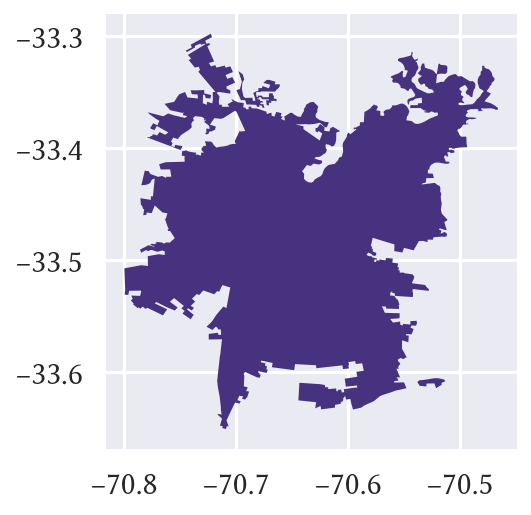

In [11]:
urban_stgo = (gpd.read_file('./input/urban_areas/', crs={'init': 'epsg:5361'})
               .to_crs({'init': 'epsg:4326'})
               .pipe(lambda x: x[x.NOMBRE == 'Santiago'].copy()))
    
urban_stgo.plot()

Esa área urbana define el borde del área que nos interesa estudiar, pero necesitamos cargar los bordes de cada distrito censal. Lo hacemos como sigue:

In [12]:
orig = (gpd.read_file('./input/R13/').assign(REGION=lambda x: x.REGION.astype(np.int))
         .assign(PROVINCIA=lambda x: x.PROVINCIA.astype(np.int))
         .assign(COMUNA=lambda x: x.COMUNA.astype(np.int))
         .assign(COD_DISTRI=lambda x: x.COD_DISTRI.astype(np.int)))
len(orig)

451

En la RM hay 451 áreas censales. Por cierto, los valores de región, provincia, comuna y distrito no vienen como números enteros, por eso debimos realizar esas operaciones `astype`.

Grafiquemos los distritos:

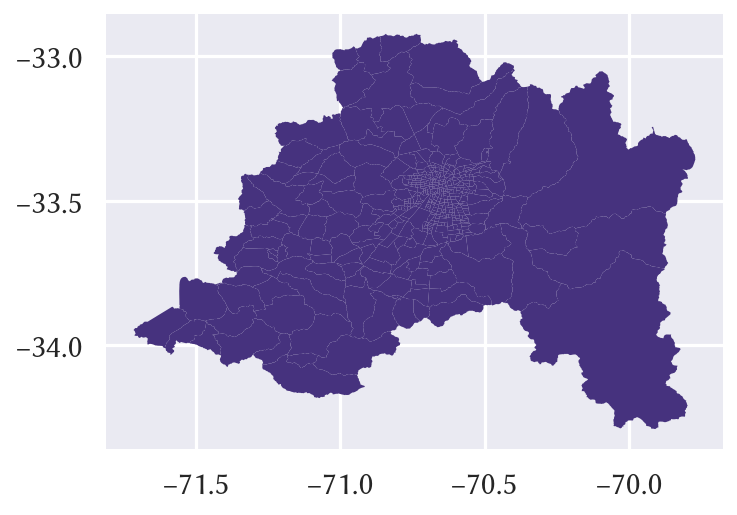

In [13]:
orig.plot()

Como está toda la región, necesitamos quedarnos con los distritos que se intersectan con el área urbana. Lo hacemos así:

In [14]:
urban_districts = (orig
         .pipe(lambda x: x.assign(geometry=x.geometry.map(lambda y: urban_stgo.loc[385].geometry.intersection(y))))
         .pipe(lambda x: x[(x.area > 0)].copy()))
len(urban_districts)

342

(Sí, ese `loc[385]` se ve un poco mágico. Te reto a que descubras qué significa :) )

Tenemos 342 distritos en el área urbana. Veámoslos:

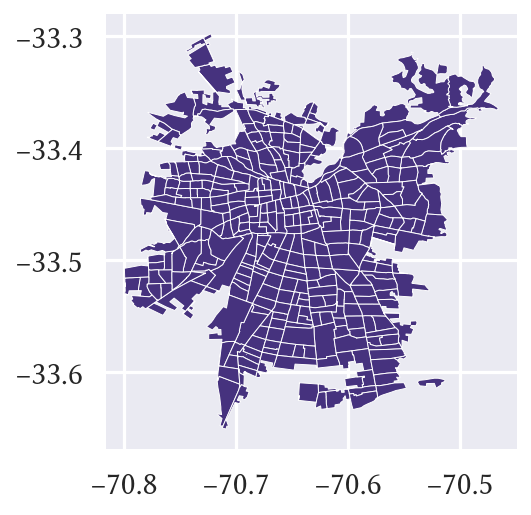

In [15]:
urban_districts.plot(edgecolor='white')

Ahora mezclémoslos con los datos.

In [16]:
urban_data = urban_districts.merge(dc_values, how='inner')

Calculemos las variables que necesitamos para responder nuestras preguntas iniciales.

In [17]:
urban_data['POPULATION'] = urban_data['HOMBRES'] + urban_data['MUJERES']
urban_data.POPULATION.describe()

count      342.000000
mean     17858.394737
std      12753.122789
min        440.000000
25%      11400.750000
50%      14643.500000
75%      20322.500000
max      98090.000000
Name: POPULATION, dtype: float64

In [18]:
urban_data['RATIO'] = ((urban_data['MUJERES'] - urban_data['HOMBRES']) / urban_data['POPULATION'] * 100)
urban_data.RATIO.describe()

count    342.000000
mean       2.742708
std        5.605334
min      -83.073011
25%        1.301957
50%        2.728653
75%        4.469270
max       11.570881
Name: RATIO, dtype: float64

In [19]:
urban_data['IMMIGRANT_%'] = urban_data['INMIGRANTES'] / urban_data['POPULATION'] * 100
urban_data['IMMIGRANT_%'].describe()

count    342.000000
mean       8.224377
std        9.434377
min        0.000000
25%        2.399305
50%        4.916366
75%        8.813560
max       53.320236
Name: IMMIGRANT_%, dtype: float64

In [20]:
urban_data['RETIRED_%'] = urban_data['EDAD_65YMAS'] / urban_data['POPULATION'] * 100
urban_data['RETIRED_%'].describe()

count    342.000000
mean      11.914783
std        4.043622
min        0.000000
25%        8.924081
50%       12.508958
75%       14.787759
max       20.260310
Name: RETIRED_%, dtype: float64

## ¡Mapas!

Ahora que calculamos las variables necesarias, grafiquemos los mapas :D

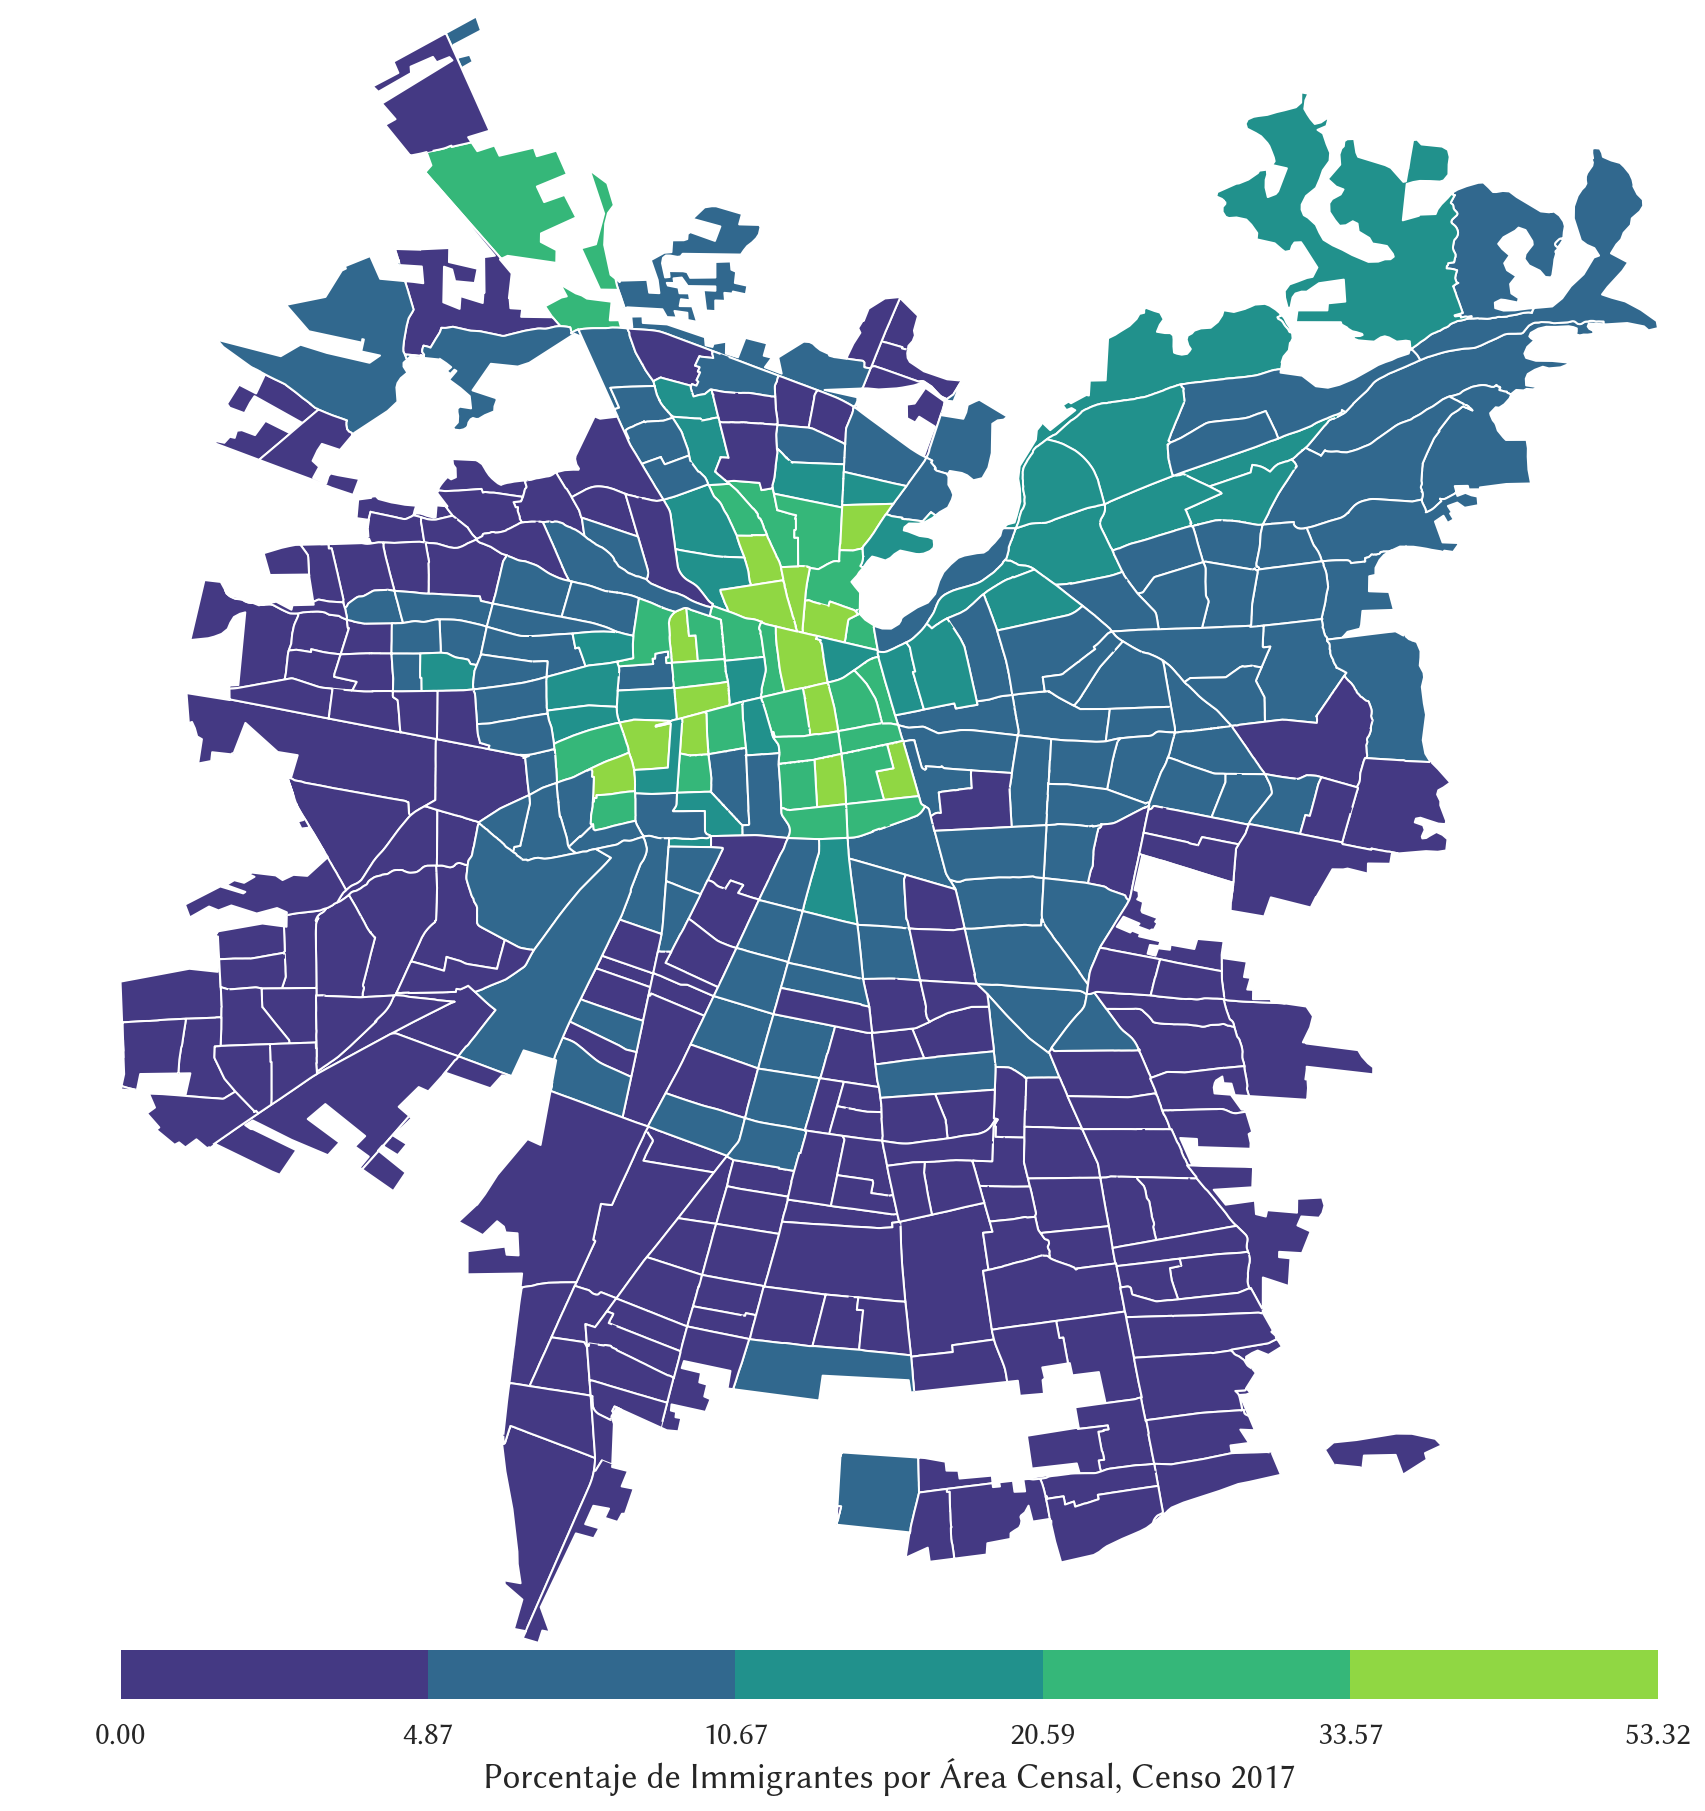

In [21]:
choropleth(urban_data, column='IMMIGRANT_%', alpha=1.0, cbar_orientation='horizontal', cbar_label='Porcentaje de Immigrantes por Área Censal, Censo 2017')
plt.savefig('migrants.png', dpi=150, bbox_inches='tight')

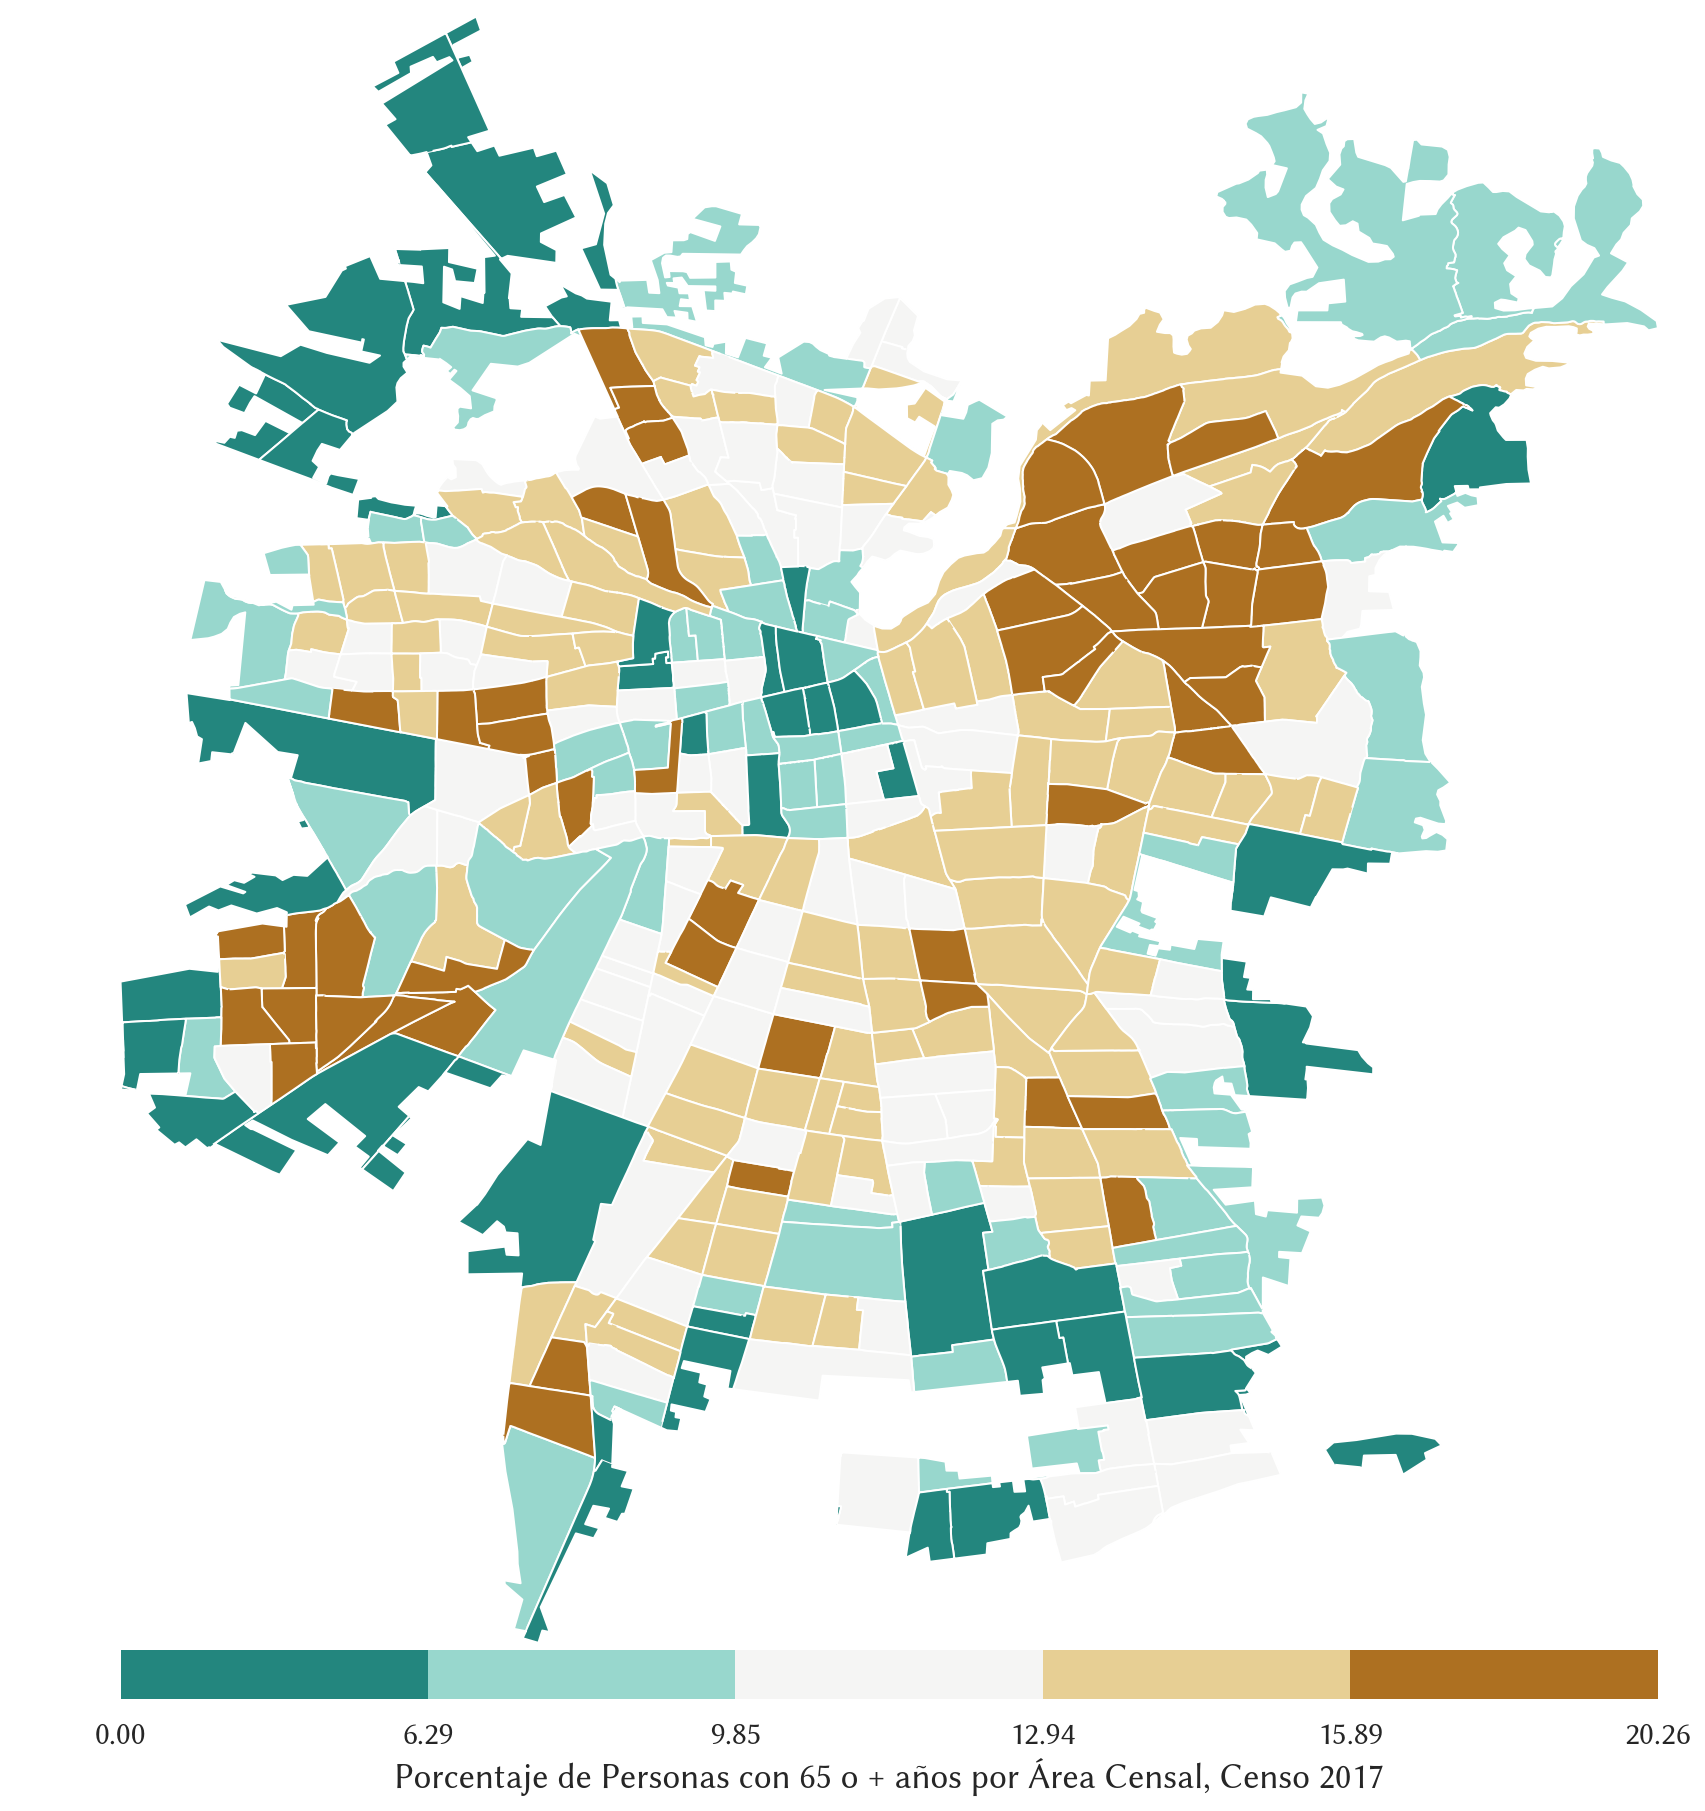

In [22]:
choropleth(urban_data, column='RETIRED_%', alpha=1.0, cbar_orientation='horizontal', palette='BrBG_r', cbar_label='Porcentaje de Personas con 65 o + años por Área Censal, Censo 2017')
plt.savefig('retired.png', dpi=150, bbox_inches='tight')

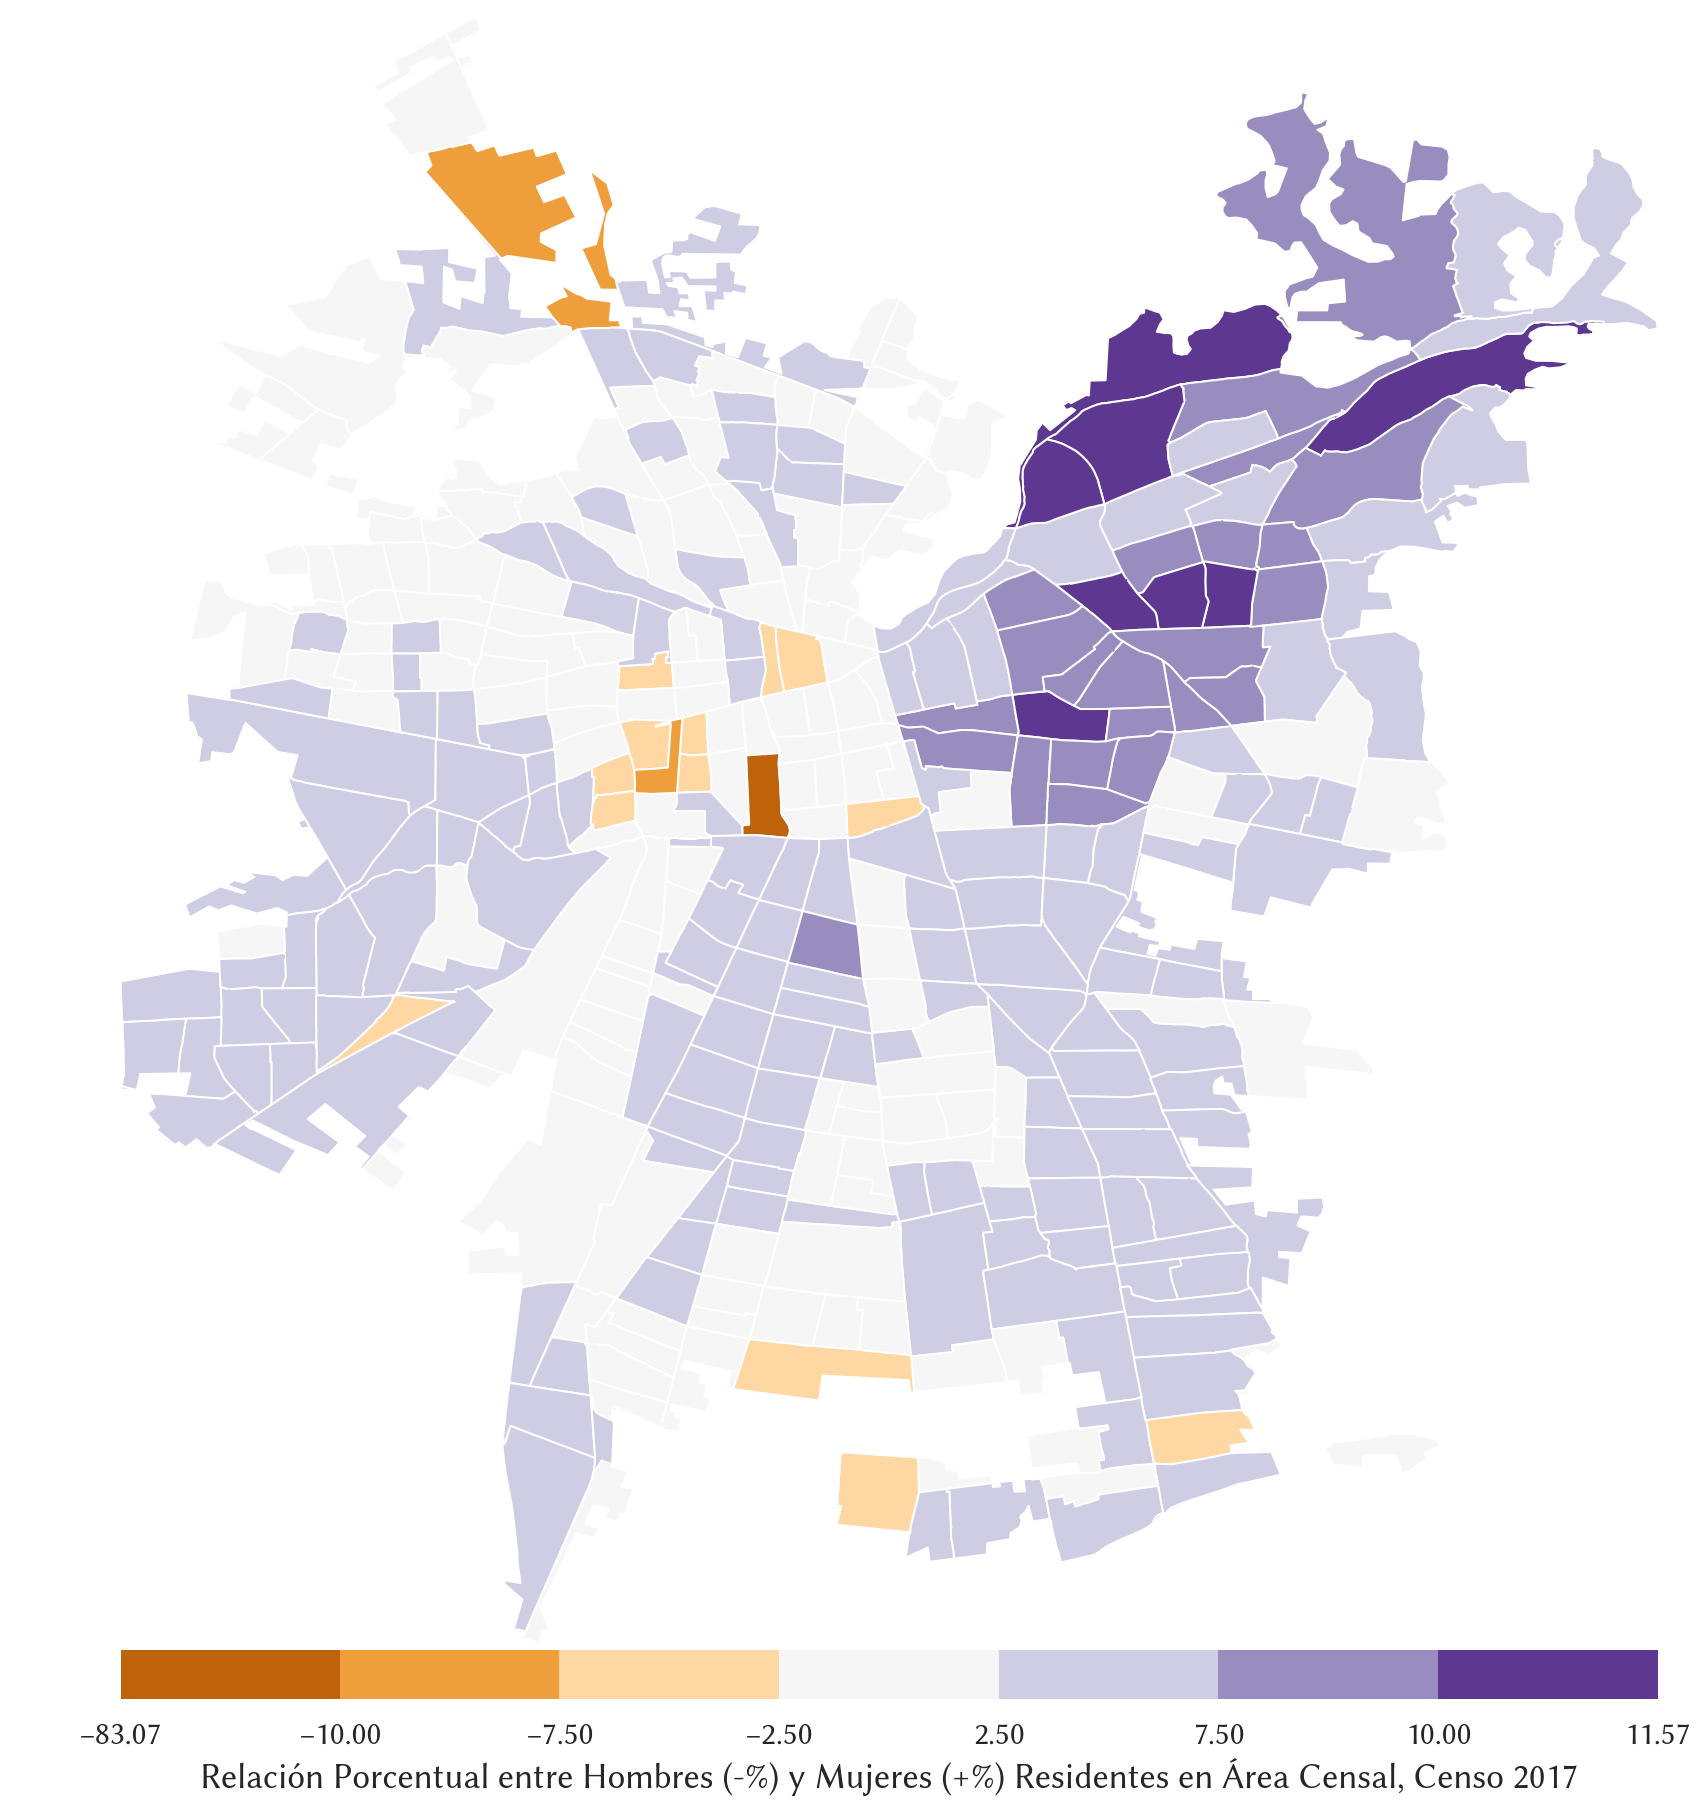

In [24]:
choropleth(urban_data, column='RATIO', alpha=1.0, cbar_orientation='horizontal', palette='PuOr', n_colors=7,
                     scheme='user_defined', user_bins=[urban_data.RATIO.min(), -10, -7.5, -2.5, 2.5, 7.5, 10, urban_data.RATIO.max()],
                     cbar_label='Relación Porcentual entre Hombres (-%) y Mujeres (+%) Residentes en Área Censal, Censo 2017')
plt.savefig('women_to_men_ratio.png', dpi=150, bbox_inches='tight')

## Fin

Con eso terminamos este ejercicio. Hay hartos caminos por seguir: 

  * ¿Cómo interpretarías estos datos?¿Qué hipótesis tienes respecto a los resultados?
  * ¿Con cuáles datasets los cruzarías?
  * ¿Qué otras ciudades te gustaría ver? En teoría solamente debemos cambiar el área urbana que estudiamos, el código debiese ser el mismo (excepto para el mapa de mujeres/hombres, en el que hay que ajustar las _bins_ de la escala de colores).
  
No dudes en contactarme con sugerencias y preguntas. El conocimiento es libre y solamente lo podemos hacer crecer entre todes :)